In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
tr_temp=pd.read_csv('ytrain.csv',usecols=['itemId','userId','rating'])

In [4]:
hold_temp=pd.read_csv('yholdout.csv',usecols=['itemId','userId','rating'])

In [5]:
te_temp=pd.read_csv('ytest.csv',usecols=['itemId','userId','rating'])

In [6]:
import math

In [7]:
movies_mean=np.zeros(shape=[1001,3])

In [8]:
user_total=np.zeros(15401)
cnt=np.zeros(15401,dtype='int64')
for i,j in tr_temp.iterrows():
    k=int(j['userId'])
    cnt[k]+=1
    user_total[k]+=j['rating']
    p=int(j['itemId'])
    movies_mean[p][0]+=1
    movies_mean[p][1]+=j['rating']

In [9]:
user_mean=np.array([ i/j for i,j in zip(user_total,cnt) ])
for x in movies_mean:
    x[2]=round(x[1]/x[0],2)
    
for x in movies_mean:
    if math.isnan(x[2]):
        x[2]=0

C:\Users\ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.
C:\Users\ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
print(movies_mean)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   3.00000000e+00   3.00000000e+00]
 ..., 
 [  7.18000000e+02   2.07100000e+03   2.88000000e+00]
 [  1.35000000e+02   3.30000000e+02   2.44000000e+00]
 [  8.60000000e+01   2.71000000e+02   3.15000000e+00]]


In [10]:
for i in range(len(user_mean)):
    if math.isnan(user_mean[i]):
        user_mean[i]=0

In [11]:
foruser=np.zeros(15401)
formovies=np.zeros(1001)
for index,j in tr_temp.iterrows():
    usr=int(j['userId'])
    mov=int(j['itemId'])
    foruser[usr]+=movies_mean[mov][2]
    formovies[mov]+=user_mean[usr]

In [12]:
import time

In [17]:
gpim=[]
gim=[]
rmse=[]
mae=[]
Beta=[i/10 for i in range(1,11)]
for beta in Beta:
    error=0
    err1=0
    err_gpim=0
    err_gim=0
    c=0
    c_gim=0
    c_gpim=0
    for index,j in hold_temp.iterrows():
        predicted_rating=0
    
        usr=int(j['userId'])
        mov=int(j['itemId'])
        actual=j['rating']
    
        usr_mean=user_mean[usr]
    
        item_mean=movies_mean[mov][2]
        usr_rated=cnt[usr]
        usr_tendency=0
        if usr_rated!=0:
            usr_tendency=(user_total[usr]-foruser[usr])/usr_rated
   
        no_of_ratings=movies_mean[mov][0]
        item_tendency=0
        if no_of_ratings!=0:
            item_tendency=(movies_mean[mov][1]-formovies[mov])/no_of_ratings
   
        if usr_tendency>=0 and item_tendency>=0:
            predicted_rating=max(usr_mean+item_tendency,item_mean+usr_tendency)
    
        elif usr_tendency<0 and item_tendency<0:
            predicted_rating=min(usr_mean+item_tendency,item_mean+usr_tendency)
    
        elif usr_tendency<0 and item_tendency>=0 and item_mean>usr_mean:
            predicted_rating=min(max(usr_mean, (item_mean+usr_tendency)*beta + (usr_mean+item_tendency)*(1-beta)),item_mean)
        
        elif usr_tendency>=0 and item_tendency<0 and item_mean<usr_mean:
            predicted_rating=min(max(item_mean, (item_mean+usr_tendency)*beta + (usr_mean+item_tendency)*(1-beta)),usr_mean)
        else:
            predicted_rating=((item_mean*beta) +usr_mean*(1-beta))
    
        error+=((actual-predicted_rating)**2)
        err1+=math.fabs(actual-predicted_rating)
        c+=1
        if actual >3:
            err_gim+=math.fabs(actual-predicted_rating)
            c_gim+=1
        if predicted_rating > 3:
            err_gpim+=math.fabs(actual-predicted_rating)
            c_gpim+=1
        #print(error)
    #print(math.sqrt(error/c))
    rmse.append(math.sqrt(error/c))
    mae.append(err1/c)
    gim.append(err_gim/c_gim)
    gpim.append(err_gpim/c_gpim)

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

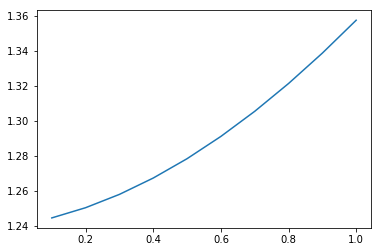

In [19]:
plt.plot(Beta,rmse)

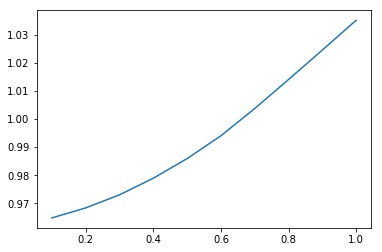

In [20]:
plt.plot(Beta,mae)

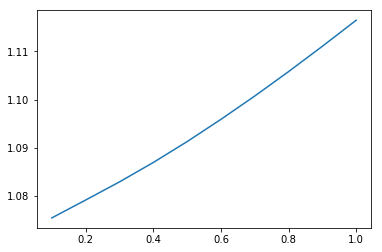

In [21]:
plt.plot(Beta,gim)

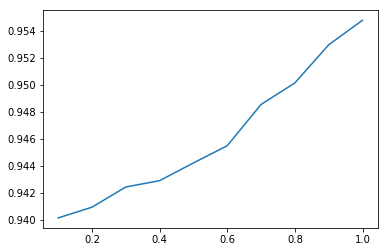

In [22]:
plt.plot(Beta,gpim)

In [23]:
final_beta=0.1

In [24]:
predicted_rating=[]
beta=final_beta
for index,j in te_temp.iterrows():
    usr=int(j['userId'])
    mov=int(j['itemId'])
    actual=j['rating']
    usr_mean=user_mean[usr]
    item_mean=movies_mean[mov][2]
    usr_rated=cnt[usr]
    usr_tendency=0
    if usr_rated!=0:
        usr_tendency=(user_total[usr]-foruser[usr])/usr_rated
   
    no_of_ratings=movies_mean[mov][0]
    item_tendency=0
    if no_of_ratings!=0:
        item_tendency=(movies_mean[mov][1]-formovies[mov])/no_of_ratings
    if usr_tendency>=0 and item_tendency>=0:
        predicted_rating.append(max(usr_mean+item_tendency,item_mean+usr_tendency))
    elif usr_tendency<0 and item_tendency<0:
        predicted_rating.append(min(usr_mean+item_tendency,item_mean+usr_tendency))
    elif usr_tendency<0 and item_tendency>=0 and item_mean>usr_mean:
        predicted_rating.append(min(max(usr_mean, (item_mean+usr_tendency)*beta + (usr_mean+item_tendency)*(1-beta)),item_mean))
    elif usr_tendency>=0 and item_tendency<0 and item_mean<usr_mean:
        predicted_rating.append(min(max(item_mean, (item_mean+usr_tendency)*beta + (usr_mean+item_tendency)*(1-beta)),usr_mean))
    else:
        predicted_rating.append(((item_mean*beta) +usr_mean*(1-beta)))
   

In [26]:
file=open('yahootendencybased.txt', 'w')

In [27]:
for item in predicted_rating:
    file.write("%s\n" % item)

In [28]:
error=0
mae=0
c=0
for ind,j in te_temp.iterrows():
    actual=j['rating'];
    #print(actual ,predicted_rating[c] )
    error+=((actual-predicted_rating[c])**2)
    mae+=(abs(actual-predicted_rating[c]))
    c+=1
#print(error)
#c=c+1
print("rmse error: ",math.sqrt(error/c))
print("mae :",(mae/c))

rmse error:  1.561657248137215
mae : 1.26329516978


In [13]:
gpim=[]
gim=[]
rmse=[]
mae=[]
Beta=[i/10 for i in range(1,11)]
for beta in Beta:
    error=0
    err1=0
    err_gpim=0
    err_gim=0
    c=0
    c_gim=0
    c_gpim=0
    for index,j in te_temp.iterrows():
        predicted_rating=0
    
        usr=int(j['userId'])
        mov=int(j['itemId'])
        actual=j['rating']
    
        usr_mean=user_mean[usr]
    
        item_mean=movies_mean[mov][2]
        usr_rated=cnt[usr]
        usr_tendency=0
        if usr_rated!=0:
            usr_tendency=(user_total[usr]-foruser[usr])/usr_rated
   
        no_of_ratings=movies_mean[mov][0]
        item_tendency=0
        if no_of_ratings!=0:
            item_tendency=(movies_mean[mov][1]-formovies[mov])/no_of_ratings
   
        if usr_tendency>=0 and item_tendency>=0:
            predicted_rating=max(usr_mean+item_tendency,item_mean+usr_tendency)
    
        elif usr_tendency<0 and item_tendency<0:
            predicted_rating=min(usr_mean+item_tendency,item_mean+usr_tendency)
    
        elif usr_tendency<0 and item_tendency>=0 and item_mean>usr_mean:
            predicted_rating=min(max(usr_mean, (item_mean+usr_tendency)*beta + (usr_mean+item_tendency)*(1-beta)),item_mean)
        
        elif usr_tendency>=0 and item_tendency<0 and item_mean<usr_mean:
            predicted_rating=min(max(item_mean, (item_mean+usr_tendency)*beta + (usr_mean+item_tendency)*(1-beta)),usr_mean)
        else:
            predicted_rating=((item_mean*beta) +usr_mean*(1-beta))
    
        error+=((actual-predicted_rating)**2)
        err1+=math.fabs(actual-predicted_rating)
        c+=1
        if actual >3:
            err_gim+=math.fabs(actual-predicted_rating)
            c_gim+=1
        if predicted_rating > 3:
            err_gpim+=math.fabs(actual-predicted_rating)
            c_gpim+=1
        #print(error)
    #print(math.sqrt(error/c))
    rmse.append(math.sqrt(error/c))
    mae.append(err1/c)
    gim.append(err_gim/c_gim)
    gpim.append(err_gpim/c_gpim)

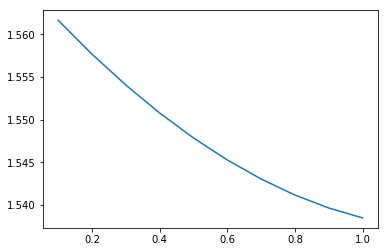

In [15]:
plt.plot(Beta,rmse)

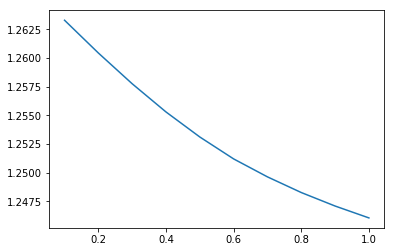

In [16]:
plt.plot(Beta,mae)

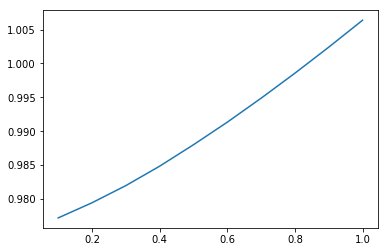

In [17]:
plt.plot(Beta,gim)

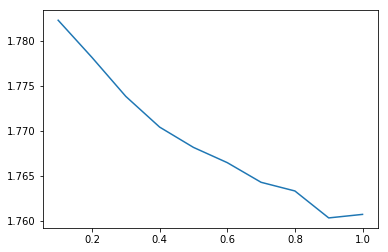

In [18]:
plt.plot(Beta,gpim)

In [19]:
rmse

[1.561657248137215,
 1.5576816281019654,
 1.554059416501759,
 1.5507787243924849,
 1.5478494645536593,
 1.5452679185845404,
 1.5430324615066144,
 1.5411483268763462,
 1.5396299694232327,
 1.5384646944287979]

In [20]:
mae

[1.2632951697803254,
 1.2604377857295,
 1.2577552710082727,
 1.2552950110184233,
 1.253111405298399,
 1.2511993841397593,
 1.2496333058973725,
 1.2482663394672917,
 1.2470897448311686,
 1.2460526367846514]

In [21]:
gim

[0.9771964261259314,
 0.9794296993702369,
 0.9819641689062507,
 0.9848331093865877,
 0.9879970738147409,
 0.9913277498215044,
 0.9948670030338861,
 0.9985610883552365,
 1.002401273569486,
 1.0063787128808415]

In [22]:
gpim

[1.7822633572765039,
 1.7781375319719603,
 1.7738169121317582,
 1.7704135098094775,
 1.7681617178456652,
 1.7664699094436567,
 1.7642905935323487,
 1.7633286674348658,
 1.760339446021142,
 1.7607309276818253]